# Ingestion and Cleaning

  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# A helper function for reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = 'dataset' 

# Define the output path for the pickle
pickle_file =  "clean_data.pickle" 

In [4]:
# Identify the columns that will be kept from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 
                'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','purpose', 
                'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high', 
                'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt','last_pymnt_d', 'recoveries'] 

# Categorize columns according to data type
float_cols = ['loan_amnt','funded_amnt','installment','annual_inc','dti','delinq_2yrs','open_acc','pub_rec','fico_range_high','fico_range_low','revol_bal','total_pymnt','recoveries']
cat_cols = ['term','grade','emp_length','home_ownership','verification_status','loan_status','purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + '/'
    
    all_files = [file for file in os.listdir(directory) if file != '.DS_Store'] # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i, dtype='str', skiprows = 1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = np.array([ 0 if is_integer(x) else 1 for x in output[i].id ])  # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][[True if idx==0 else False for idx in invalid_rows] ]  # remove invalid rows
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory dataset/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid 

### Combine the files

In [8]:
data_cs = pd.concat(files_cs.values(),sort=False, ignore_index = True)
       # reset index with drop = True

## Prepare Final Dataset

In [10]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [11]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 2777776 rows


### Typecast the columns

In [12]:
# typecast the columns based on feature types

for i in float_cols:
    final_data[i] = final_data[i].astype(float)# typecast float columns

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = [clean_perc(x) for x in final_data[i] ] # apply clean_perc to percentage columns

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = [clean_date(x) for x in final_data[i]] # typecast date cloumns to datatime using clean_date

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
for i in cat_cols:
    final_data[i] = [ None if x is '' else x for x in final_data[i] ] # for categorical features if the value is null/empty set it to None

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Calculate returns for each loan

In [16]:
# Define the names of the four returns strategies
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [17]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data =final_data[ final_data['loan_length'] != 0  ] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

/Users/tjy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Removed 12361 rows


### M1-Pessimistic Method

Return = $\frac{p-f}{f} *\frac{12}{t}$

where 
* f is the total amount invested in the loan, 
* p is the total amount repaid, and
* t is the term length of the loan in months.

In [18]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = (final_data['total_pymnt'] - final_data['funded_amnt'])/final_data['funded_amnt']*12/final_data['term_num']

### M2-Optimistic Method

Return = $\frac{p−f}{f}*\frac{12}{m}$

where
* m is the actual length of the loan in months; i.e., the number of months from the date the loan was issued to the date the last payment was made.

In [19]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return


final_data['ret_OPT'] = (final_data['total_pymnt'] - final_data['funded_amnt'])/final_data['funded_amnt']*12/final_data['loan_length']

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']

### Method 3

Return = $[\frac{p}{m} * (\frac{1-(1+i)^m}{1-(1+i)})*(1+i)^{T-m}-f]*\frac{1}{f}*\frac{12}{T} $

In [20]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length # (p-recoveries)/m

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * final_data.loan_length.map(lambda x: (1-(1+i)**x))/(1-(1+i)) # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * remaining_months.map(lambda x:(1+i)**x) 

    # Find the percentage return
    ret_val = (12/T) * (final_return - final_data.funded_amnt)* 1/ final_data.funded_amnt # f= final_data.funded_amnt
    return ret_val

In [21]:
final_data['ret_INTa'] = ret_method_3(60, 0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60, 0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [22]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3] # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [23]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print("field name: ",i) # print field name
        print("number of distinct values is", len(set(final_data[i]))) # print number of distinct values
        print(final_data[i].groupby(final_data[i]).count()) # for each distinct value print the number of occurances
        print("")
        print("")

In [24]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

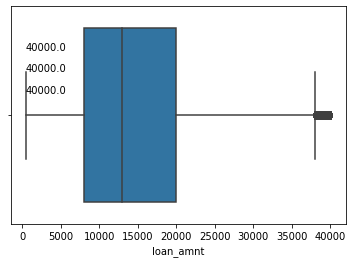

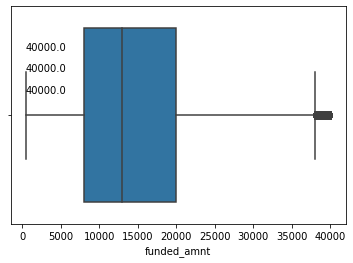

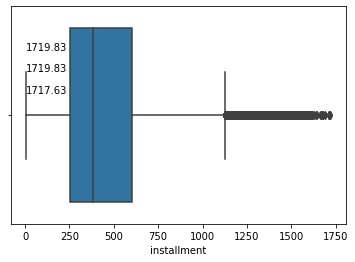

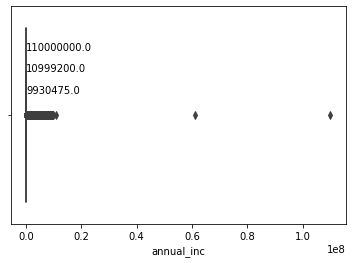

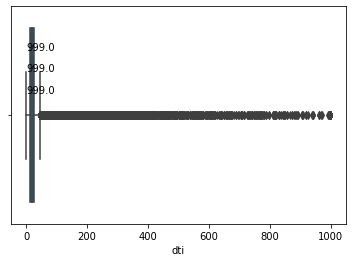

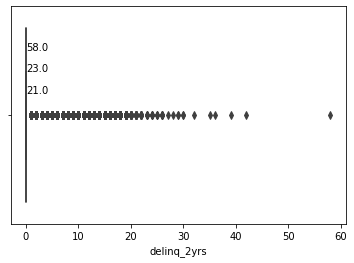

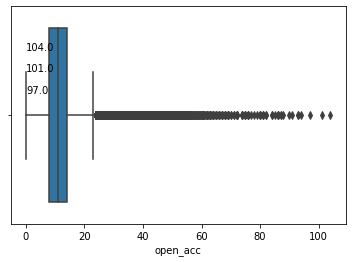

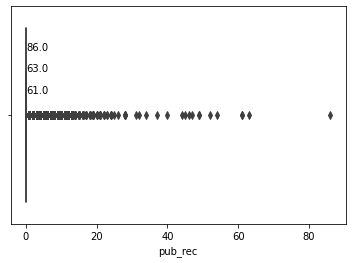

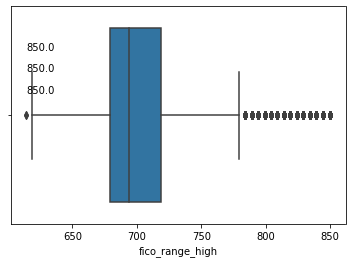

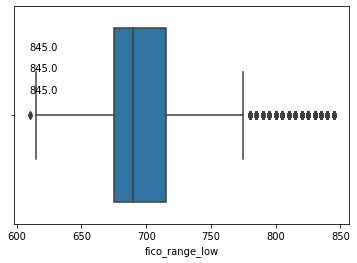

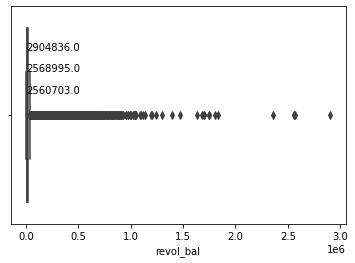

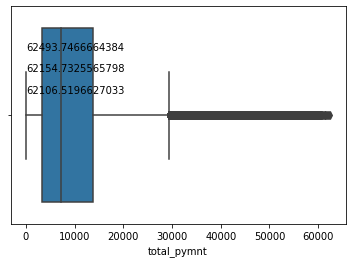

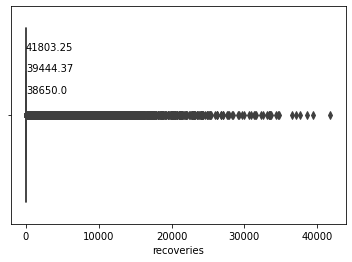

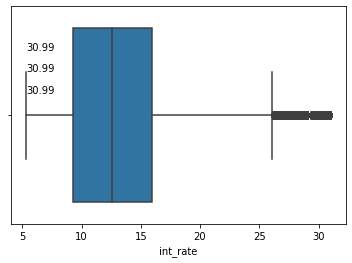

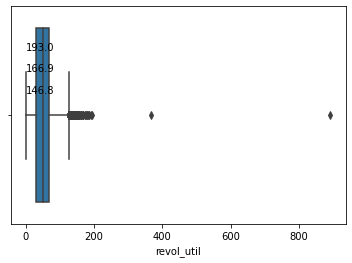

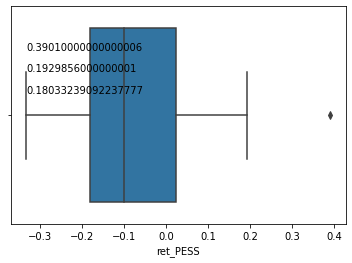

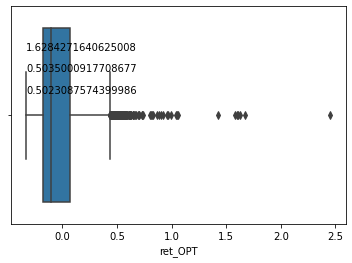

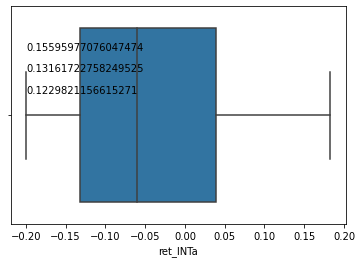

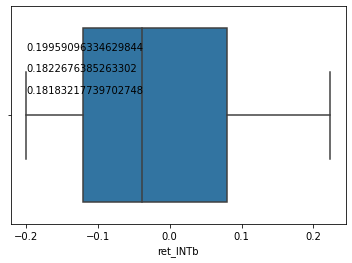

field name:  term
number of distinct values is 2
term
 36 months    1949756
 60 months     815659
Name: term, dtype: int64


field name:  grade
number of distinct values is 7
grade
A    596277
B    811304
C    768632
D    397211
E    138329
F     41596
G     12066
Name: grade, dtype: int64


field name:  emp_length
number of distinct values is 12
emp_length
1 year       183001
10+ years    898370
2 years      247379
3 years      219762
4 years      166566
5 years      171829
6 years      123700
7 years      110120
8 years      107507
9 years       91449
< 1 year     253650
Name: emp_length, dtype: int64


field name:  home_ownership
number of distinct values is 6
home_ownership
ANY            3393
MORTGAGE    1359007
NONE             55
OTHER           182
OWN          312178
RENT        1090600
Name: home_ownership, dtype: int64


field name:  verification_status
number of distinct values is 3
verification_status
Not Verified        997623
Source Verified    1066701
Verified          

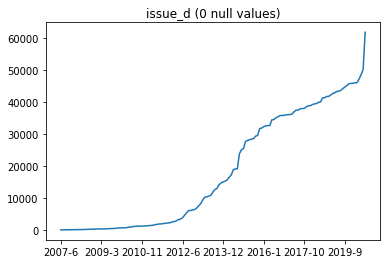

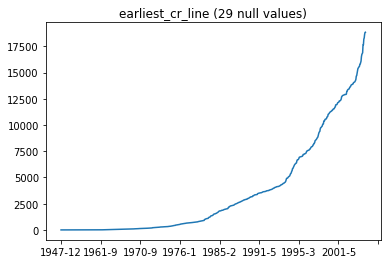

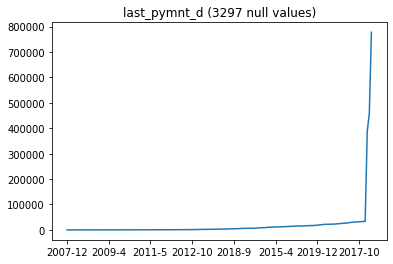

In [25]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Handle outliers

In [26]:
# There are quite a few outliers. 
# We want to delete them
n_rows = len(final_data)

final_data = final_data[final_data['annual_inc'] < 10999200] # remove outliers based 1st obvious feature
final_data = final_data[final_data['dti'] < 800] # remove outliers based 2nd obvious feature
final_data = final_data[final_data['delinq_2yrs'] < 30]
final_data = final_data[final_data['pub_rec'] < 60]
final_data = final_data[final_data['revol_bal'] < 2000000]
final_data = final_data[final_data['recoveries'] < 35000] # remove outliers based 6th obvious feature


print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3139 rows


In [27]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 1622766 rows


In [28]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d']>=datetime.date(2010,1,1)]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6529 rows


### Drop null values

In [29]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3827 rows


### Visualize clean data

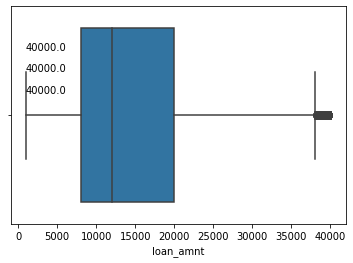

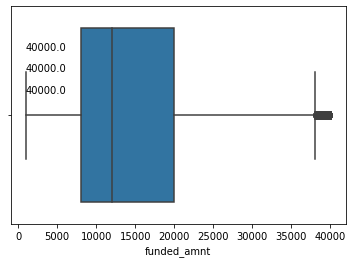

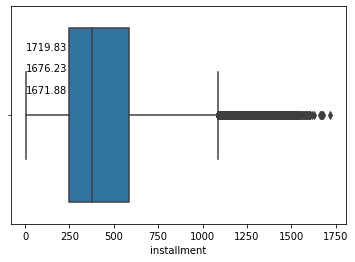

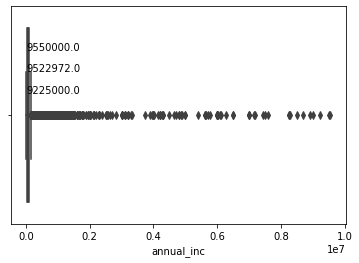

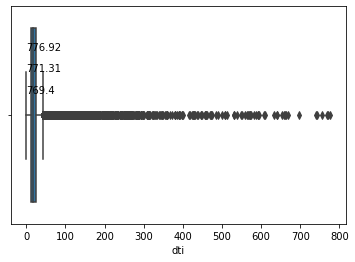

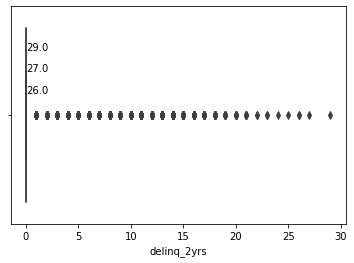

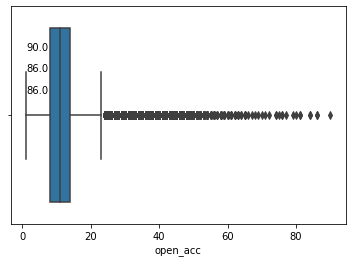

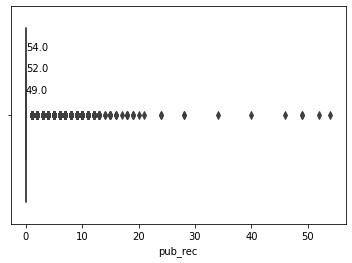

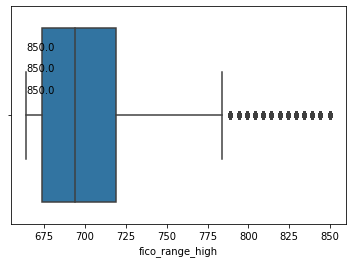

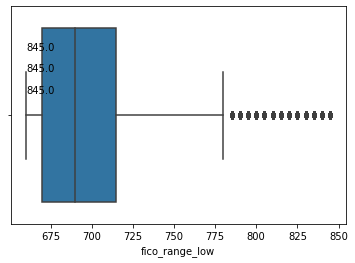

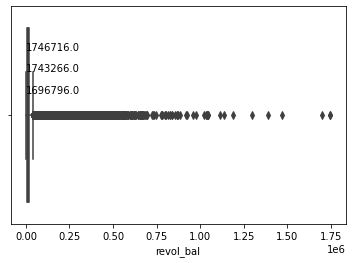

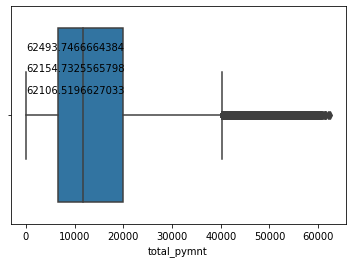

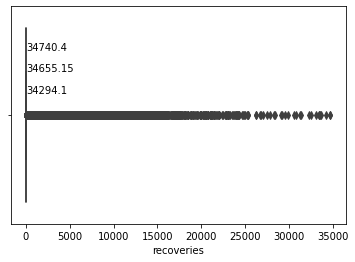

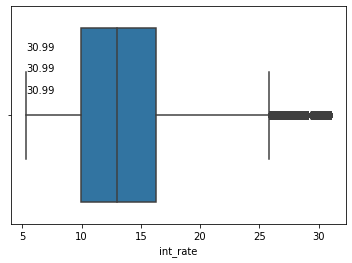

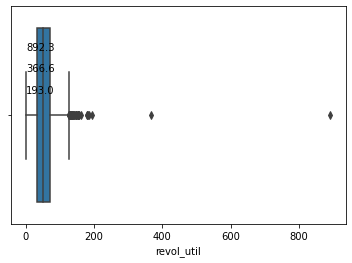

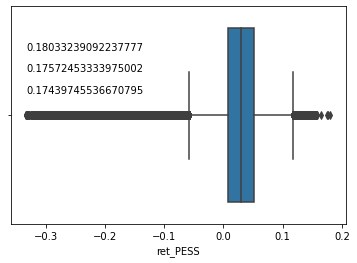

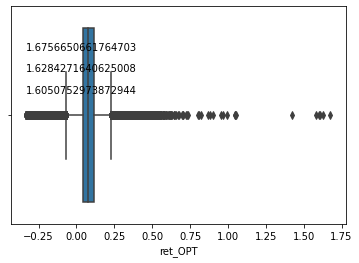

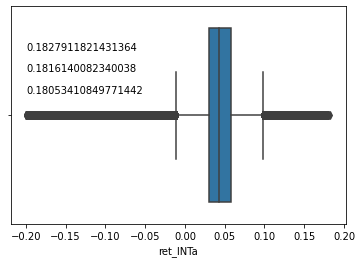

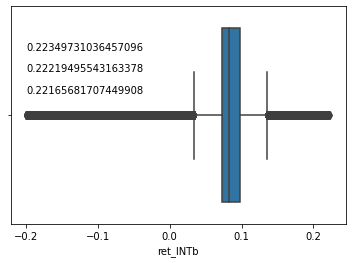

field name:  term
number of distinct values is 2
term
 36 months    851558
 60 months    277596
Name: term, dtype: int64


field name:  grade
number of distinct values is 7
grade
A    206261
B    322619
C    311301
D    176401
E     79003
F     26557
G      7012
Name: grade, dtype: int64


field name:  emp_length
number of distinct values is 12
emp_length
1 year        74101
10+ years    368018
2 years      101979
3 years       90540
4 years       68225
5 years       71611
6 years       54189
7 years       51078
8 years       50385
9 years       41109
< 1 year      90920
Name: emp_length, dtype: int64


field name:  home_ownership
number of distinct values is 6
home_ownership
ANY            616
MORTGAGE    564519
NONE            44
OTHER           49
OWN         119929
RENT        443997
Name: home_ownership, dtype: int64


field name:  verification_status
number of distinct values is 3
verification_status
Not Verified       364409
Source Verified    422175
Verified           342570
Na

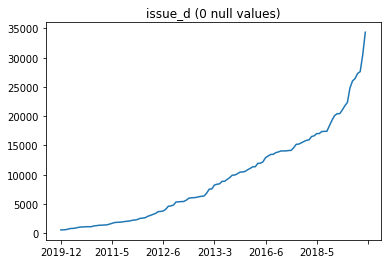

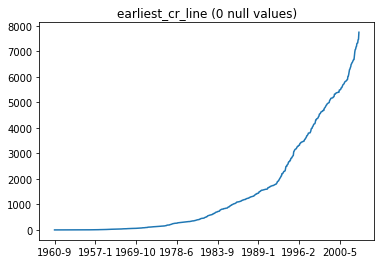

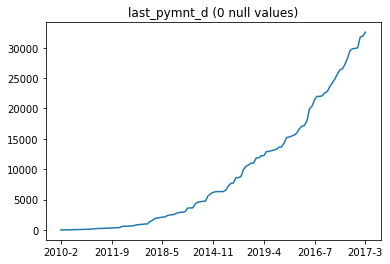

In [30]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

### Visualize Correlation

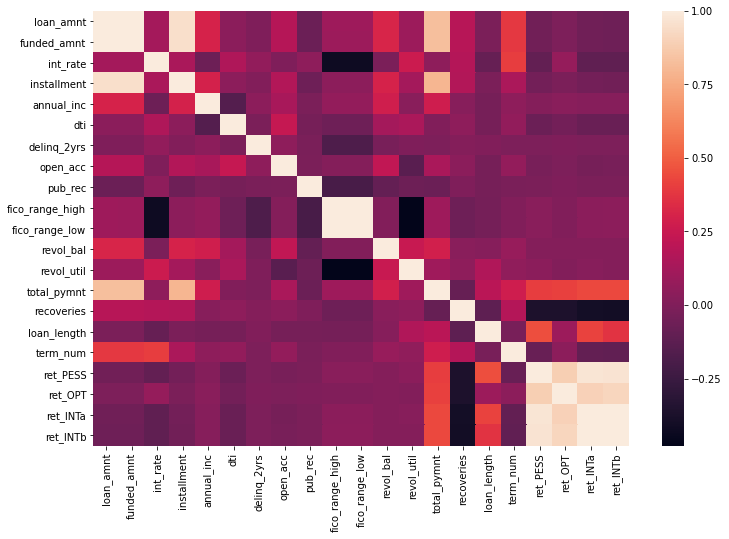

In [31]:
import seaborn as sns
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot
correlation=final_data.corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation, ax=ax)
plt.show()

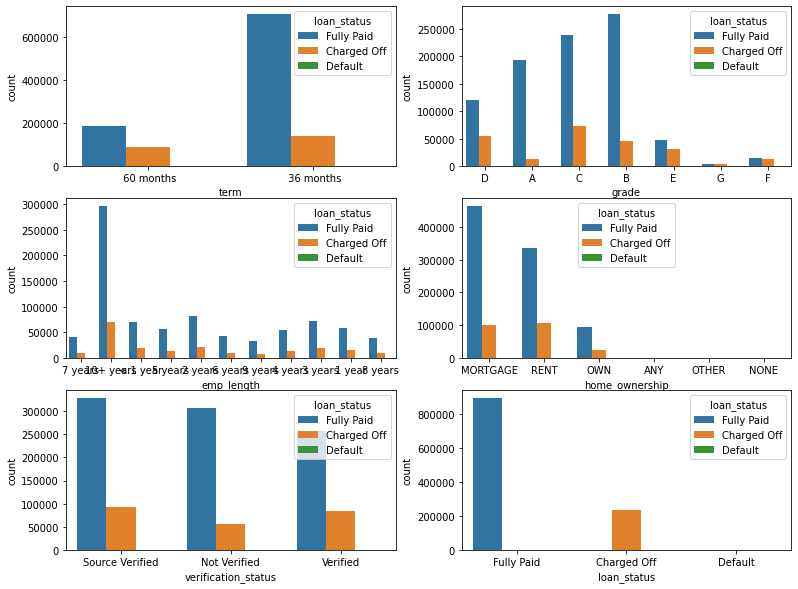

In [32]:
# Visualize relation between loan status and categorical features
plt.figure(figsize = (13,10))
plt.subplot(321)
sns.countplot(x=cat_cols[0], data=final_data, hue = 'loan_status')
plt.subplot(322)
sns.countplot(x=cat_cols[1], data=final_data, hue = 'loan_status')
plt.subplot(323)
sns.countplot(x=cat_cols[2], data=final_data, hue = 'loan_status')
plt.subplot(324)
sns.countplot(x=cat_cols[3], data=final_data, hue = 'loan_status')
plt.subplot(325)
sns.countplot(x=cat_cols[4], data=final_data, hue = 'loan_status')
plt.subplot(326)
sns.countplot(x=cat_cols[5], data=final_data, hue = 'loan_status');


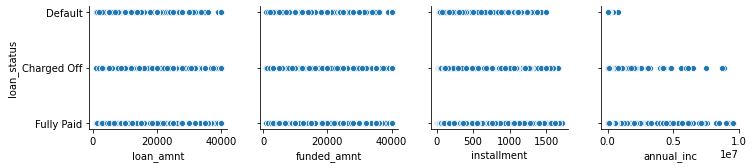

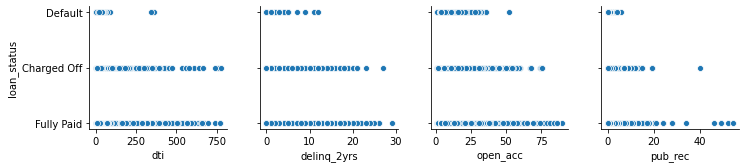

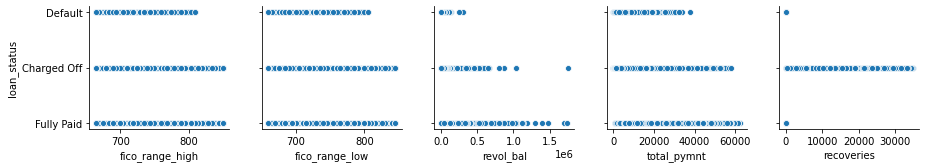

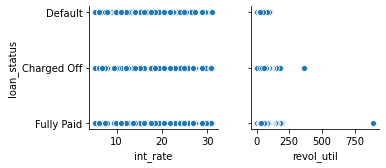

In [33]:
# the relationship between continuous feature and loan status
sns.pairplot(data = final_data, x_vars=float_cols[:4], y_vars= ['loan_status'])
sns.pairplot(data = final_data, x_vars=float_cols[4:8], y_vars= ['loan_status']) # sns pairplot or scatter plot. Refer to recitations
sns.pairplot(data = final_data, x_vars=float_cols[8:], y_vars= ['loan_status'])
sns.pairplot(data = final_data, x_vars=perc_cols, y_vars= ['loan_status'])

### Data Exploration


In [34]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT =  final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)*100 ) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)*100 ) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)*100 ) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)*100 ) # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate)) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,18.266862,6.792365,7.214495,3.931202,1.136230,2.854984,6.553607
B,28.571745,14.211810,10.879870,4.970205,1.005543,2.742727,6.394496
C,27.569402,23.378980,14.210935,5.303028,-0.018043,2.006670,5.566789
D,15.622404,31.391545,18.010837,5.769945,-0.746643,1.364283,4.824111
E,6.996654,39.527613,21.249919,5.994803,-1.354329,0.768132,4.102711
F,2.351938,45.799601,24.753810,6.425555,-1.655851,0.328003,3.571048
G,0.620996,49.201369,27.281276,6.644308,-2.734723,-0.590610,2.574658


### Save a Pickle

In [35]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = list(set(continuous_features)- set(["total_pymnt"])-set(["recoveries"]))

we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, because these two features are known after the you finished your investment. So you can't use these data when you make prediction.

In [36]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )